<a href="https://colab.research.google.com/github/SCOR8PION/Book-Recommendation-Engine-using-KNN/blob/main/Copy_of_fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib as mpl

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2023-06-08 18:26:07--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.6’

book-crossings.zip. 100%[===================>]  24.88M   116MB/s    in 0.2s    

2023-06-08 18:26:08 (116 MB/s) - ‘book-crossings.zip.6’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [ ]:
# add your code here - consider creating a new cell for each section of code
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [ ]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [ ]:
# find all books with same title and author 
book_groups = df_books.groupby(['title', 'author']).agg(copies=('isbn', list), count=('isbn', 'count'))

In [ ]:
# Update all ratings to point to the first ISBN found for each book
isbn_list = book_groups.query('count > 3')['copies'].tolist()
for ids in isbn_list:
  anchor, to_replace_list = ids[0], ids[1:]
  df_ratings.loc[df_ratings['isbn'].isin(to_replace_list), 'isbn'] = anchor

In [ ]:
# Identify duplicate books based on title and author
duplicate_books = df_books.groupby(['title', 'author']).title.agg(['count']).reset_index().query('count > 1')
duplicate_books_count = duplicate_books['count'].sum() - len(duplicate_books)
# Identify duplicate ratings based on ISBN and user
duplicate_ratings = df_ratings.groupby(['isbn', 'user']).isbn.agg(['count']).reset_index().query('count > 1')
duplicate_ratings_count = duplicate_ratings['count'].sum() - len(duplicate_books)
# print the counts of duplicate books and duplicate ratings 
print("Duplicate Books Count:", duplicate_books_count)
print("Duplicate Ratings Count:", duplicate_ratings_count)

Duplicate Books Count: 20175
Duplicate Ratings Count: -13092


In [ ]:
# Books
books_count_before = len(df_books)

books_with_ratings = df_books.merge(df_ratings, on='isbn')

grouped_by_isbn = books_with_ratings.groupby(['isbn', 'title']).rating.agg(['count', 'mean']).reset_index()

books_min_count = 100

acceptable_books = grouped_by_isbn.query('count >= {}'.format(books_min_count))['isbn'].tolist()
grouped_by_isbn = grouped_by_isbn[grouped_by_isbn['isbn'].isin(acceptable_books)]
df_books = df_books[df_books['isbn'].isin(acceptable_books)]

books_count_after = len(df_books)

b_percent_change = round((books_count_before - books_count_after) / books_count_before * 100, 2)

print('Removed {:,} rows ({}%) of books with less than {} reviews'.format(books_count_before - books_count_after, b_percent_change, books_min_count))


Removed 270,611 rows (99.72%) of books with less than 100 reviews


In [ ]:
users_count_before = len(df_ratings)
users_min_count = 100

# Count the number of ratings per user and calculate the mean rating
grouped_by_user = df_ratings.groupby('user').rating.agg(['count', 'mean']).reset_index()

# Filter out users with less than the minimum number of ratings
acceptable_users = grouped_by_user[grouped_by_user['count'] >= users_min_count]['user'].tolist()

# Filter the original DataFrame to keep only the ratings of acceptable users
df_users = df_ratings[df_ratings['user'].isin(acceptable_users)]

users_count_after = len(df_users)
users_removed = users_count_before - users_count_after
percent_change = round((users_removed / users_count_before) * 100, 2)

print('Removed {:,} rows ({}%) of users with less than {} ratings'.format(users_removed, percent_change, users_min_count))


Removed 490,975 rows (42.7%) of users with less than 100 ratings


In [ ]:
grouped_by_user = df_ratings.groupby(['user'])
user_ratings = grouped_by_user['rating'].agg(['sum', 'count', 'mean']).reset_index()

print('--- BASIC STATS\n')
user_count = len(grouped_by_user['user'])
review_count = len(df_ratings)
most_active_list = user_ratings.sort_values(by='count')
most_active_user = most_active_list.iloc[-1];
print('There are {:,} reviews in the database written by {:,} users'.format(review_count, user_count))
print('The most active user (ID: #{}) has written {:,} reviews\n'.format(most_active_user['user'], int(most_active_user['count'])))

print('\n--- WHERE DO MOST OF OUR REVIEWS COME FROM?\n')

--- BASIC STATS

There are 1,149,780 reviews in the database written by 105,283 users
The most active user (ID: #11676.0) has written 13,602 reviews


--- WHERE DO MOST OF OUR REVIEWS COME FROM?



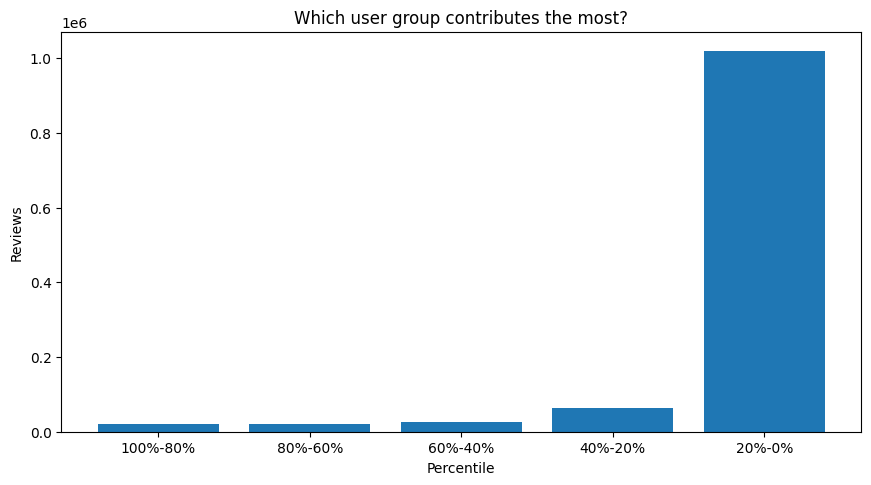

In [ ]:
# Graph
SLICE_NUMBERS = 5
step_size = int(user_count/SLICE_NUMBERS)
percentile = int(100 / SLICE_NUMBERS);
labels_percentile = ['{}%-{}%'.format(100-(n*percentile), 100-((n+1)*percentile)) for n in range(SLICE_NUMBERS)]
count_per_percentile = []
quartile = [round(((n+1)*percentile/100)-0.2, 1) for n in range(SLICE_NUMBERS+1)]
reviews_distribution = most_active_list['count'].groupby(
    pd.qcut(most_active_list['count'].rank(method='first'), q=quartile)
).sum()
most_active_list['distribution'] = reviews_distribution

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
ax.bar(labels_percentile, reviews_distribution.tolist())
plt.title('Which user group contributes the most?')
plt.xlabel('Percentile')
plt.ylabel('Reviews')
plt.show()

In [ ]:
# Hard numbers
top_reviewers_count = most_active_list.iloc[-step_size:]['count'].sum()
print('\nThe top {}% of users contributed to {}% of reviews'.format(percentile, round(top_reviewers_count/review_count*100,2)))
print("\nInsight: Most of our reviews come from a small group of 'superusers' who have a lot of opinions to share\n")
print('\n--- HOW MANY REVIEWS DO USERS USUALLY LEAVE?\n')


The top 20% of users contributed to 88.73% of reviews

Insight: Most of our reviews come from a small group of 'superusers' who have a lot of opinions to share


--- HOW MANY REVIEWS DO USERS USUALLY LEAVE?



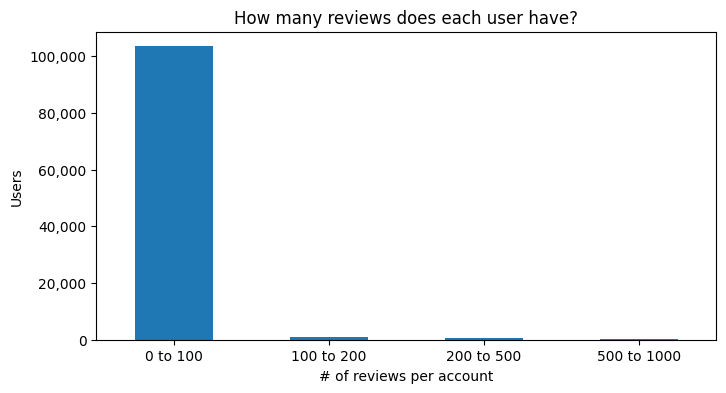

In [ ]:
# Graph 2
binned = pd.cut(user_ratings['count'], bins=[0,100,200,500,1000])
ax = binned.value_counts(sort=False).plot.bar(rot=0, figsize=(8,4))
ax.set_xticklabels(["{} to {}".format(c.left, c.right) for c in binned.cat.categories])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('How many reviews does each user have?')
plt.ylabel("Users")
plt.xlabel("# of reviews per account")
plt.show()

In [ ]:
# Hard numbers 2
LOW_COUNT_THRESHOLD = 10
inactive_users = user_ratings[user_ratings['count'] < LOW_COUNT_THRESHOLD]
inactive_count = len(inactive_users)
inactive_percentage = round(inactive_count/user_count*100,2)
print('\nThere are {:,} users ({}%) who have written less than {} reviews'.format(inactive_count, inactive_percentage, LOW_COUNT_THRESHOLD));

print("\nInsight: Most users write less than 10 reviews")

print('\n--- WHAT IS THE RELATIONSHIP BETWEEN ENGAGEMENT RATE AND AVERAGE REVIEW SCORES?\n')


There are 92,186 users (87.56%) who have written less than 10 reviews

Insight: Most users write less than 10 reviews

--- WHAT IS THE RELATIONSHIP BETWEEN ENGAGEMENT RATE AND AVERAGE REVIEW SCORES?



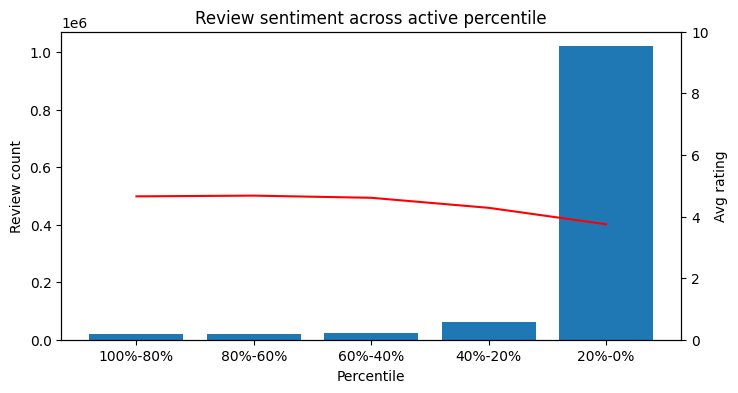

In [ ]:
# Graph 3
quartile = [round(((n+1)*percentile/100)-0.2, 1) for n in range(SLICE_NUMBERS+1)]
score_distribution = most_active_list['mean'].groupby(
    pd.qcut(most_active_list['count'].rank(method='first'), q=quartile)
).mean()
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(labels_percentile, reviews_distribution.tolist())
ax2 = ax.twinx() 
ax2.plot(labels_percentile, score_distribution.tolist(), color='red')  
ax.set_xlabel('Percentile')
ax.set_ylabel('Review count')
ax2.set_ylabel('Avg rating')
ax2.set_ylim(0,10)

plt.title('Review sentiment across active percentile')
plt.xlabel('Review count')
plt.show()

In [ ]:
# Hard numbers 2
score_range = (0, 6)
reviews_within_range = df_ratings.query('{} <= rating <= {}'.format(score_range[0], score_range[1]))
within_range_count = len(reviews_within_range)
within_range_percent = round(within_range_count/review_count * 100, 2)
avg_rating = df_ratings['rating'].mean()
print('\nThe average review rating is {:.2f}'.format(avg_rating))
print('\nThere are {:,} reviews ({}%) that are between {} and {}'.format(within_range_count, within_range_percent, score_range[0], score_range[1]))

print('\nInsight: There is no strong correlation between sustained engagement and review ratings\n')

print('\n--- WHAT REVIEW SCORES ARE MOST OFTEN POSTED ON THE SITE?\n')


The average review rating is 2.87

There are 823,436 reviews (71.62%) that are between 0 and 6

Insight: There is no strong correlation between sustained engagement and review ratings


--- WHAT REVIEW SCORES ARE MOST OFTEN POSTED ON THE SITE?



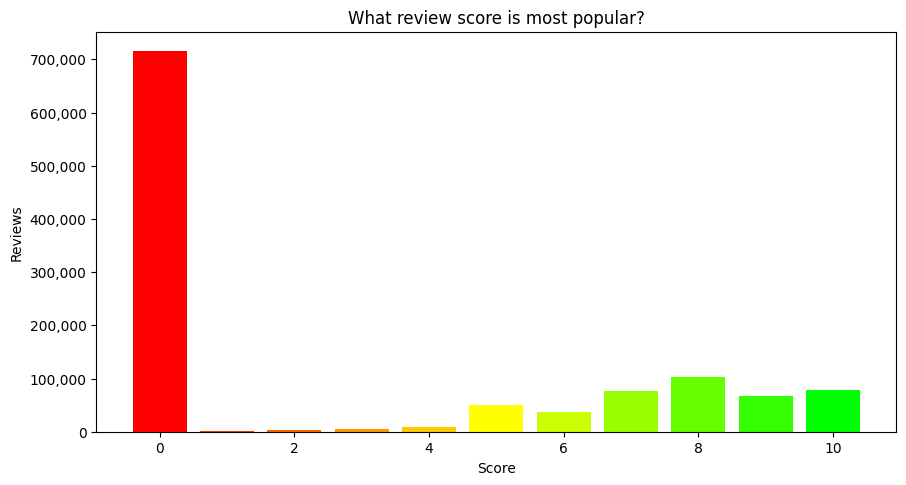

In [ ]:
# Graph 4
grouped_by_score = df_ratings.groupby(['rating']).count()
scores = df_ratings['rating'].unique().tolist()
scores.sort()
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
colors = ['#FF0000','#FF3300', '#ff6600', '#ff9900', '#FFCC00','#FFFF00', '#ccff00', '#99ff00', '#66ff00', '#33ff00', '#00FF00']
ax.bar(scores, grouped_by_score['user'], color=colors)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('What review score is most popular?')
plt.xlabel('Score')
plt.ylabel('Reviews')
plt.show()

In [ ]:
# Hard numbers 3
low_score_threshold = 2
reviews_within_range = df_ratings.query('rating < {}'.format(low_score_threshold))
within_range_count = len(reviews_within_range)
within_range_percent = round(within_range_count/review_count * 100, 2)
avg_rating = df_ratings['rating'].mean()
print('\nThe average review rating is {:.2f}'.format(avg_rating))
print('\nThere are {:,} reviews ({}%) with a score lower than {}'.format(within_range_count, within_range_percent, low_score_threshold))


The average review rating is 2.87

There are 717,879 reviews (62.44%) with a score lower than 2


In [ ]:
# How many users are chronic haters?
HATER_THRESHOLD = 3
haters = user_ratings[user_ratings['mean'] < HATER_THRESHOLD]
haters_count = len(haters)
hater_percentage = round(haters_count/user_count*100,2)
print('\nThere are {:,} users ({}%) who have an average review score lower than {}'.format(haters_count, hater_percentage, HATER_THRESHOLD))

print('\nInsight: Either our users tend to have negative opinions about the books or they are more likely to write reviews about the books they didn\'t like\n')


There are 38,881 users (36.93%) who have an average review score lower than 3

Insight: Either our users tend to have negative opinions about the books or they are more likely to write reviews about the books they didn't like



--- BASIC STATS

There are 768 books registered in the database


--- WHAT ARE THE BOOKS THAT DRAW THE MOST HEAT & LOVE?



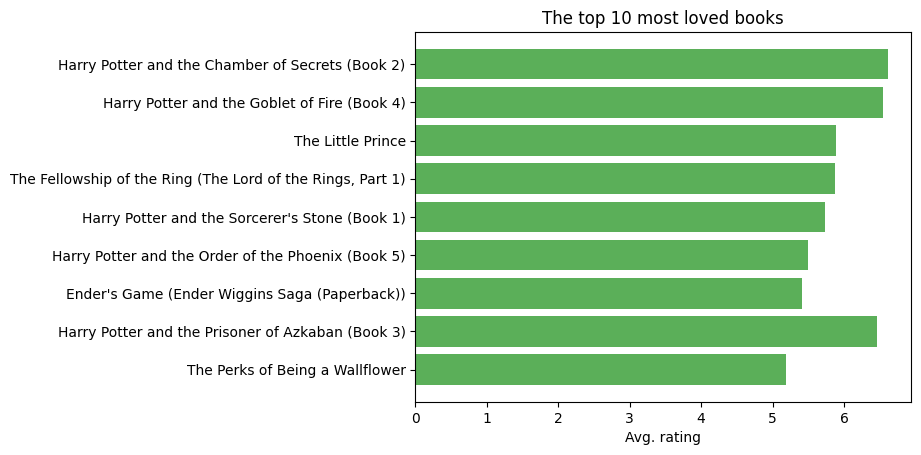

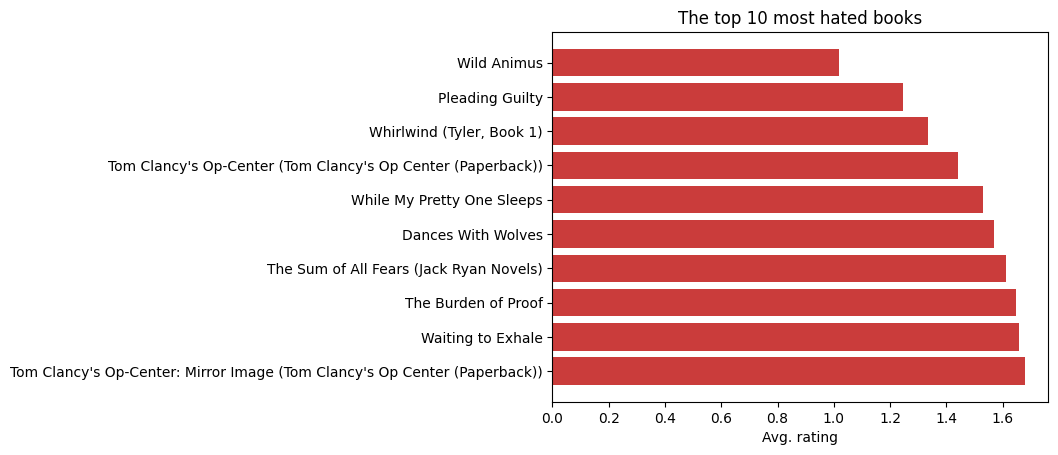


 Insight: Our most popular books is "Harry Potter and the Chamber of Secrets (Book 2)" and our most disliked one is "Wild Animus"


--- WHO ARE THE AUTHORS THAT DRAW THE MOST HEAT & LOVE?



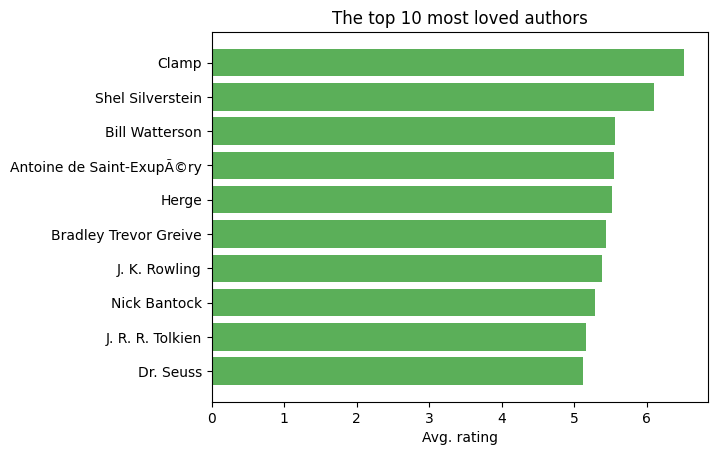

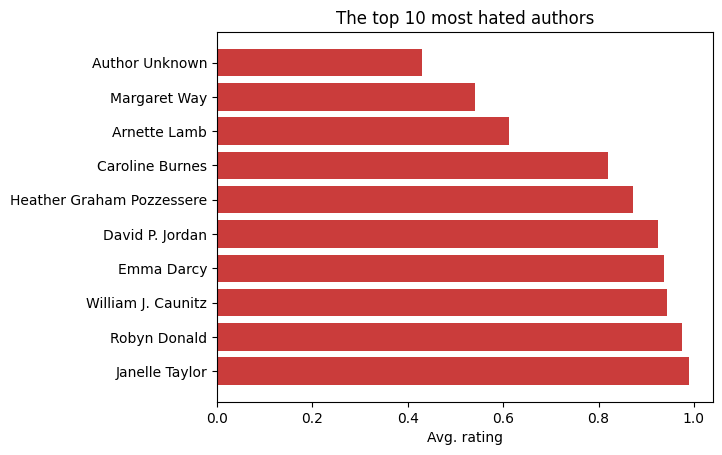


 Insight: Our most popular author is "Clamp" and our most disliked one is "Author Unknown"



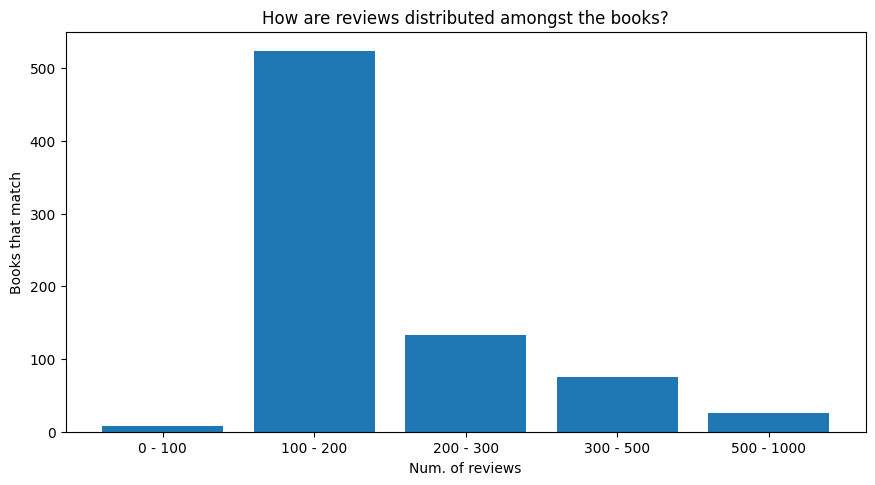


Insight: Over 3.39% of our books have more than 200 reviews.



In [ ]:
### BOOKS GRAPHS AND VISUALS----
print('--- BASIC STATS\n')
books_count = len(df_books)
print('There are {:,} books registered in the database\n'.format(books_count))

# Top 10 most rated books
most_rated_books = grouped_by_isbn.sort_values(by='count').iloc[-10:]

print('\n--- WHAT ARE THE BOOKS THAT DRAW THE MOST HEAT & LOVE?\n')
books_sorted_by_rating = grouped_by_isbn.query('count >= 100').sort_values(by='mean')
most_loved_books = books_sorted_by_rating.iloc[-10:]
most_hated_books = books_sorted_by_rating.iloc[:10].iloc[::-1]
plt.barh(most_loved_books['title'], most_loved_books['mean'], color='#5baf59')
plt.xlabel("Avg. rating")
plt.title("The top 10 most loved books")
plt.show()
print('\n')
plt.barh(most_hated_books['title'], most_hated_books['mean'], color='#ca3c3b')
plt.xlabel("Avg. rating")
plt.title("The top 10 most hated books")
plt.show()

print('\n Insight: Our most popular books is "{}" and our most disliked one is "{}"\n'.format(most_loved_books.values[-1][1], most_hated_books.values[-1][1]))

print('\n--- WHO ARE THE AUTHORS THAT DRAW THE MOST HEAT & LOVE?\n')
grouped_by_author = books_with_ratings.groupby(['author']).rating.agg(['count', 'mean']).reset_index()
authors_sorted_by_rating = grouped_by_author.query('count >= 100').sort_values(by='mean')
most_loved_authors = authors_sorted_by_rating.iloc[-10:]
most_hated_authors = authors_sorted_by_rating.iloc[:10].iloc[::-1]

plt.barh(most_loved_authors['author'], most_loved_authors['mean'], color='#5baf59')
plt.xlabel("Avg. rating")
plt.title("The top 10 most loved authors")
plt.show()
print('\n')
plt.barh(most_hated_authors['author'], most_hated_authors['mean'], color='#ca3c3b')
plt.xlabel("Avg. rating")
plt.title("The top 10 most hated authors")
plt.show()

print('\n Insight: Our most popular author is "{}" and our most disliked one is "{}"\n'.format(most_loved_authors.values[-1][0], most_hated_authors.values[-1][0]))

# How are reviews distributed?
bin_books_percentile = pd.cut(grouped_by_isbn['count'], bins=[0, 100, 200, 300, 500, 1000])
bin_counts = bin_books_percentile.value_counts().sort_index()
bin_labels = ['{} - {}'.format(c.left, c.right) for c in bin_books_percentile.values.categories]
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
ax.bar(bin_labels, bin_counts)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Books that match')
plt.xlabel('Num. of reviews')
plt.title('How are reviews distributed amongst the books?')
plt.show()

# Hard numbers
if not bin_counts.empty:
    last_bin_percentage = round(bin_counts.iloc[-1]/books_count*100, 2)
    bin_right_edge = bin_books_percentile.values[-1].right
    print('\nInsight: Over {}% of our books have more than {} reviews.\n'.format(last_bin_percentage, bin_right_edge))
else:
    print('\nInsight: There are no books with reviews in the given dataset.\n')


In [ ]:
# FORMAT THE LAST DATA BEFORE CREATING MODAL
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

df = df_ratings
counts1 = df['user'].value_counts()
counts2 = df['isbn'].value_counts()

df = df[~df['user'].isin(counts1[counts1 < 200].index)]
df = df[~df['isbn'].isin(counts2[counts2 < 100].index)]


merged_df = pd.merge(right=df, left = df_books, on="isbn")
merged_df = merged_df.drop_duplicates(subset=["title", "user"])

books_features_pivot = merged_df.pivot(
  index='title',
  columns='user',
  values='rating'
).fillna(0)

mat_books_features = csr_matrix(books_features_pivot.values)

In [ ]:
## function to return recommended books - this will be tested
def get_recommends(book = "", n = 5):
  """
  make top n books recommendations
  Parameters
  ----------
  book: str, name of user input book
  n: int, top n recommendations
  """
  # Prepare for model
  pivot = books_features_pivot
  titles = list(pivot.index.values)
  data = pivot.values

  def title_2_index(title):
    ind = titles.index(title)
    return data[ind,:]

  def index_2_title(ind):
    return titles[ind]


  # Build model
  model = NearestNeighbors(metric="cosine",algorithm="brute", p=2)
  model.fit(data)

  # Run model to get recommendations
  idx = title_2_index(book)
  distances, indices = model.kneighbors(
    np.reshape(idx,[1,-1]),
    n_neighbors=n+1
  )

  raw_recommends = sorted(
    list(
      zip(
        indices.squeeze().tolist(),
        distances.squeeze().tolist()
      )
    ),
    key=lambda x: x[1]
  )[1:]

  # print results
  recommended_books = []
  print('Recommendations for {}:'.format(book))
  for i, (idx, dist) in enumerate(raw_recommends):
      dist = dist
      recommended_books.append([index_2_title(idx), dist])
      print('{0}: {1}, with distance of {2:,.2f}'.format(i+1, index_2_title(idx), dist))
  print('-----------------')
  return [book, recommended_books]

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

Recommendations for Where the Heart Is (Oprah's Book Club (Paperback)):
1: The Lovely Bones: A Novel, with distance of 0.72
2: I Know This Much Is True, with distance of 0.77
3: The Surgeon, with distance of 0.77
4: The Weight of Water, with distance of 0.77
5: I'll Be Seeing You, with distance of 0.80
-----------------
["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Lovely Bones: A Novel', 0.7234864234924316], ['I Know This Much Is True', 0.7677075266838074], ['The Surgeon', 0.7699410915374756], ['The Weight of Water', 0.7708583474159241], ["I'll Be Seeing You", 0.8016210794448853]]]
Recommendations for Where the Heart Is (Oprah's Book Club (Paperback)):
1: The Lovely Bones: A Novel, with distance of 0.72
2: I Know This Much Is True, with distance of 0.77
3: The Surgeon, with distance of 0.77
4: The Weight of Water, with distance of 0.77
5: I'll Be Seeing You, with distance of 0.80
-----------------
You haven't passed yet. Keep trying!
